<a href="https://colab.research.google.com/github/smishra9/Advance-Machine-Learning/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the **Data** 

In [41]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle.json': b'{"username":"sumitduttmishra","key":"1085ef955849970755c6c937d023bddb"}'}

In [43]:

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [44]:
!kaggle competitions download -c dogs-vs-cats

train.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [45]:

!unzip -qq train.zip
!unzip -qq test1.zip

replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


We have downloaded our data.

###Question 1
Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of500(like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

Copying images to training, validation, and test directories

In [55]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
shutil.rmtree("./cats_vs_dogs_small",ignore_errors=True)
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

Building the model


Instantiating a small convnet for dogs vs. cats classification

In [56]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [57]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 41, 41, 128)       7385

We made a model having 4 conv2D layers and 4 maxpooling layers. We can see it very clearly that we havent made a big model but still the parameters count is high i.e. 991,041


Configuring the model for training

In [58]:

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


**Data preprocessing**

Using image_dataset_from_directory to read the images

In [59]:
### Managing the file direcotry; Dividing the file to training(1000), testing(500) and validation(500) .
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)


In [60]:
##Displaying the shapes of the data and labels yielded by the Dataset
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)



Fitting the model using a Dataset

In [61]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/35
63/63 [==============================] - 8s 107ms/step - loss: 0.7566 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5610
Epoch 2/35
63/63 [==============================] - 7s 104ms/step - loss: 0.7388 - accuracy: 0.5255 - val_loss: 0.6893 - val_accuracy: 0.5360
Epoch 3/35
63/63 [==============================] - 7s 105ms/step - loss: 0.6938 - accuracy: 0.5960 - val_loss: 0.6523 - val_accuracy: 0.6060
Epoch 4/35
63/63 [==============================] - 7s 104ms/step - loss: 0.6740 - accuracy: 0.6360 - val_loss: 0.7172 - val_accuracy: 0.5610
Epoch 5/35
63/63 [==============================] - 7s 105ms/step - loss: 0.6243 - accuracy: 0.6710 - val_loss: 0.6157 - val_accuracy: 0.6360
Epoch 6/35
63/63 [==============================] - 7s 104ms/step - loss: 0.5842 - accuracy: 0.6915 - val_loss: 0.5438 - val_accuracy: 0.7170
Epoch 7/35
63/63 [==============================] - 7s 104ms/step - loss: 0.5652 - accuracy: 0.7120 - val_loss: 0.5384 - val_accuracy: 0.7480
Epoch 


Displaying curves of loss and accuracy during training

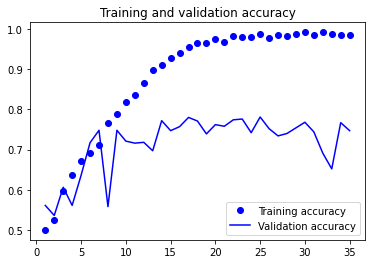

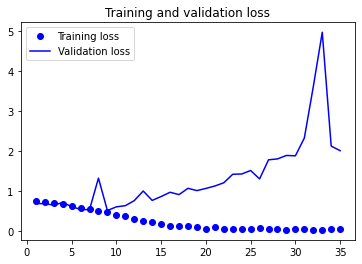

In [62]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the test set

In [63]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 49ms/step - loss: 0.5777 - accuracy: 0.7240
Test accuracy: 0.724


We can see that: The model is training well on the training but after a certain point we can see some overfitting. On the other hand validation and test accuracy is not improving a lot.

For reducing overfitting we are using data augmentaion and dropout.


**Using data augmentation and Dropout**

In data augmentation we flip, rotate and zoom images. We can also move the image along x and y axis and we can distort high frequency by adding some noise.

In [64]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.4),
    ]
)

Displaying some randomly augmented training images



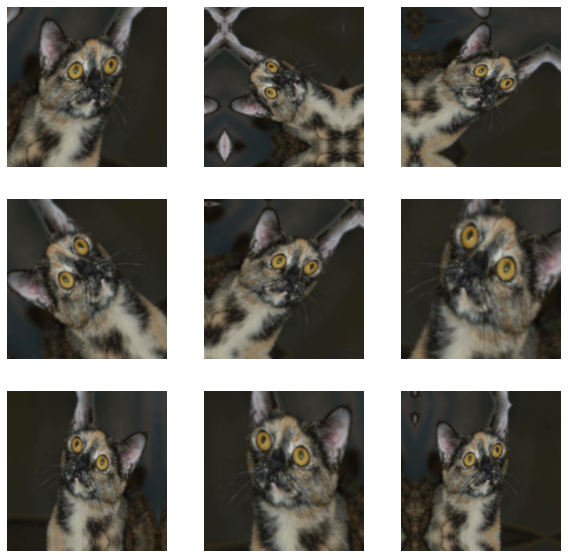

In [65]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

We have flipped, zoomed and rotated a sample of images.

New convnet that includes image augmentation and dropout



In [66]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


Training the regularized convnet

In [67]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=55,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/55
63/63 [==============================] - 9s 113ms/step - loss: 0.7233 - accuracy: 0.5070 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/55
63/63 [==============================] - 7s 110ms/step - loss: 0.6945 - accuracy: 0.5125 - val_loss: 0.7065 - val_accuracy: 0.5000
Epoch 3/55
63/63 [==============================] - 7s 110ms/step - loss: 0.7135 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5350
Epoch 4/55
63/63 [==============================] - 7s 111ms/step - loss: 0.6942 - accuracy: 0.5425 - val_loss: 0.6741 - val_accuracy: 0.6260
Epoch 5/55
63/63 [==============================] - 7s 110ms/step - loss: 0.6884 - accuracy: 0.5975 - val_loss: 0.7741 - val_accuracy: 0.5070
Epoch 6/55
63/63 [==============================] - 7s 110ms/step - loss: 0.6570 - accuracy: 0.6320 - val_loss: 0.6570 - val_accuracy: 0.5730
Epoch 7/55
63/63 [==============================] - 7s 110ms/step - loss: 0.6548 - accuracy: 0.6260 - val_loss: 0.6407 - val_accuracy: 0.6350
Epoch 

We will train our model after using data augmentation and dropout technique for reducing overfitting. 


Evaluating the model on the test set

In [68]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 51ms/step - loss: 0.4492 - accuracy: 0.7960
Test accuracy: 0.796


We can see that training data accuracy went up . We can clearly say that these two techniques are helpful in reducing overfitting.

2. Increasing training sample size. Pickning any amount. Keeping the validation and test samples the same as above. Optimizing the network (again training from scratch). 

Copying images to training, validation, and test directories

In [84]:
import os, shutil, pathlib

original_dir_2 = pathlib.Path("train")
shutil.rmtree("./cats_vs_dogs_small",ignore_errors=True)
new_base_dir_2 = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train_2", start_index=0, end_index=2000)
make_subset("validation_2", start_index=2000, end_index=2500)
make_subset("test_2", start_index=2500, end_index=3000)


Building the model


Instantiating a small convnet for dogs vs. cats classification

In [85]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [86]:

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 41, 41, 128)       7385


Configuring the model for training

In [87]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Data preprocessing


Using image_dataset_from_directory to read images

In [88]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_2",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_2",
    image_size=(180, 180),
    batch_size=32)
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)



Displaying the shapes of the data and labels yielded by the Dataset

In [89]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Fitting the model using a Dataset

In [90]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_updated_train_size.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 13s 92ms/step - loss: 0.6809 - accuracy: 0.5437 - val_loss: 0.6844 - val_accuracy: 0.6230
Epoch 2/30
125/125 [==============================] - 12s 91ms/step - loss: 0.6630 - accuracy: 0.5965 - val_loss: 0.6871 - val_accuracy: 0.5280
Epoch 3/30
125/125 [==============================] - 12s 91ms/step - loss: 0.6520 - accuracy: 0.6168 - val_loss: 0.6133 - val_accuracy: 0.6760
Epoch 4/30
125/125 [==============================] - 12s 90ms/step - loss: 0.5995 - accuracy: 0.6768 - val_loss: 0.5488 - val_accuracy: 0.7140
Epoch 5/30
125/125 [==============================] - 12s 91ms/step - loss: 0.5653 - accuracy: 0.7017 - val_loss: 0.5631 - val_accuracy: 0.7050
Epoch 6/30
125/125 [==============================] - 12s 92ms/step - loss: 0.5187 - accuracy: 0.7425 - val_loss: 0.5018 - val_accuracy: 0.7690
Epoch 7/30
125/125 [==============================] - 12s 92ms/step - loss: 0.4807 - accuracy: 0.7660 - val_loss: 0.4814 - val_accuracy:


Displaying curves of loss and accuracy during training

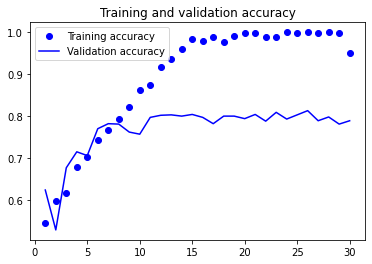

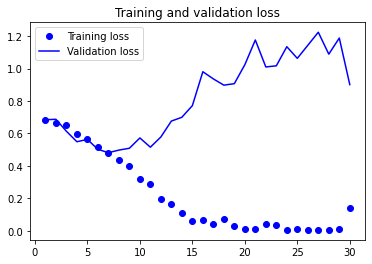

In [91]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


Evaluating the model on the test set

In [92]:
test_model = keras.models.load_model("convnet_from_scratch_updated_train_size.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 52ms/step - loss: 0.5328 - accuracy: 0.7320
Test accuracy: 0.732


Here also the model is performing well on training set but not doing good on Validation and test sets. Thus for reducing overfitting we will do data augmentaion and dropout.

Using data augmentation and Dropout

Define a data augmentation stage to add to an image model

In [93]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.4),
    ]
)


Displaying some randomly augmented training images

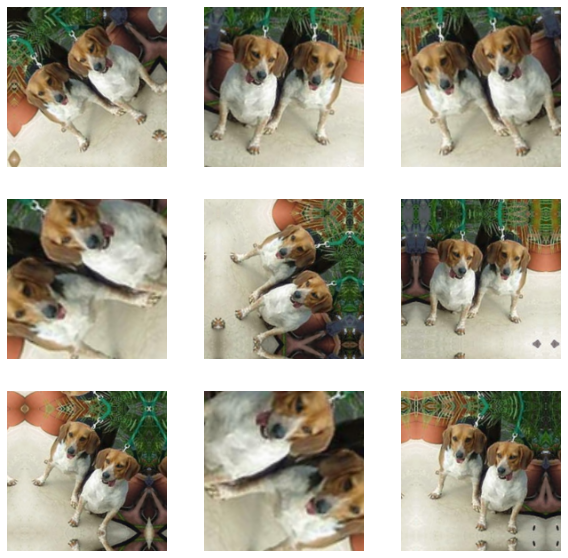

In [94]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


Defining a new convnet that includes image augmentation and dropout

In [95]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


Training the regularized convnet

In [96]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_updated_train_size_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=55,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/55
125/125 [==============================] - 14s 98ms/step - loss: 0.6923 - accuracy: 0.5200 - val_loss: 0.6890 - val_accuracy: 0.5420
Epoch 2/55
125/125 [==============================] - 12s 97ms/step - loss: 0.6900 - accuracy: 0.5225 - val_loss: 0.6904 - val_accuracy: 0.5300
Epoch 3/55
125/125 [==============================] - 12s 96ms/step - loss: 0.6870 - accuracy: 0.5345 - val_loss: 0.6915 - val_accuracy: 0.5150
Epoch 4/55
125/125 [==============================] - 12s 96ms/step - loss: 0.6867 - accuracy: 0.5355 - val_loss: 0.6863 - val_accuracy: 0.5470
Epoch 5/55
125/125 [==============================] - 12s 96ms/step - loss: 0.6843 - accuracy: 0.5425 - val_loss: 0.6762 - val_accuracy: 0.5530
Epoch 6/55
125/125 [==============================] - 12s 97ms/step - loss: 0.6839 - accuracy: 0.5410 - val_loss: 0.6586 - val_accuracy: 0.6020
Epoch 7/55
125/125 [==============================] - 12s 96ms/step - loss: 0.6818 - accuracy: 0.5595 - val_loss: 0.6717 - val_accuracy:

We can see improvement here. Model is converging at a good rate; neither too fast nor too slow and training and validation accuracy are moving at almost similar rates.

Evaluating the model on the test set

In [97]:
test_model = keras.models.load_model(
    "convnet_from_scratch_updated_train_size_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 47ms/step - loss: 0.3782 - accuracy: 0.8390
Test accuracy: 0.839


3. Changing  training sample to achieve better performance than those from Steps 1 and 2. Sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

Copying images to training, validation, and test directories

In [98]:
import os, shutil, pathlib

original_dir_3 = pathlib.Path("train")
new_base_dir_3 = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train_3", start_index=0, end_index=2500)
make_subset("validation_3", start_index=2500, end_index=3000)
make_subset("test_3", start_index=3000, end_index=3500)

Building the model

Instantiating a small convnet for dogs vs. cats classification

In [99]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [100]:

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 41, 41, 128)       7385


Configuring the model for training

In [101]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


Data preprocessing

Using image_dataset_from_directory to read images

In [102]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_3",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_3",
    image_size=(180, 180),
    batch_size=32)
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break
      


Found 5000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)


Displaying the shapes of the data and labels yielded by the Dataset

In [103]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Fitting the model using a Dataset

In [104]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_final.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/35
157/157 [==============================] - 15s 90ms/step - loss: 0.6932 - accuracy: 0.5232 - val_loss: 0.7040 - val_accuracy: 0.5000
Epoch 2/35
157/157 [==============================] - 14s 87ms/step - loss: 0.6568 - accuracy: 0.6010 - val_loss: 0.6456 - val_accuracy: 0.6290
Epoch 3/35
157/157 [==============================] - 14s 87ms/step - loss: 0.6144 - accuracy: 0.6606 - val_loss: 0.5981 - val_accuracy: 0.6740
Epoch 4/35
157/157 [==============================] - 14s 88ms/step - loss: 0.5634 - accuracy: 0.7050 - val_loss: 0.6059 - val_accuracy: 0.6840
Epoch 5/35
157/157 [==============================] - 14s 88ms/step - loss: 0.5350 - accuracy: 0.7268 - val_loss: 0.5667 - val_accuracy: 0.7190
Epoch 6/35
157/157 [==============================] - 14s 87ms/step - loss: 0.4947 - accuracy: 0.7616 - val_loss: 0.5729 - val_accuracy: 0.7160
Epoch 7/35
157/157 [==============================] - 14s 87ms/step - loss: 0.4457 - accuracy: 0.7940 - val_loss: 0.5627 - val_accuracy:


Displaying curves of loss and accuracy during training

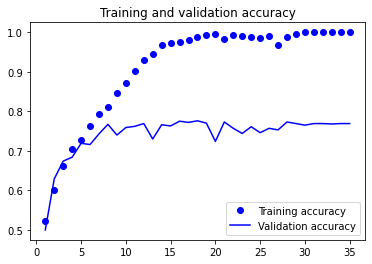

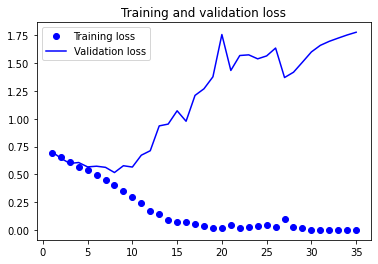

In [105]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [106]:
test_model = keras.models.load_model("convnet_from_scratch_final.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 51ms/step - loss: 0.4552 - accuracy: 0.7840
Test accuracy: 0.784



Using data augmentation and Dropout

Define a data augmentation stage to add to an image model

In [107]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.4),
    ]
)

Displaying some randomly augmented training images

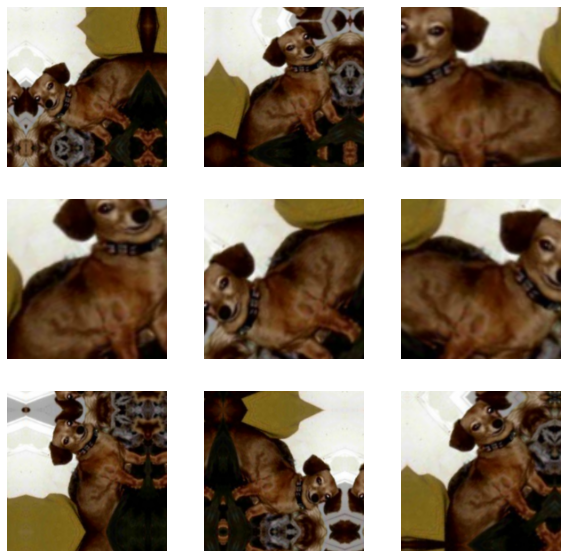

In [108]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Defining a new convnet that includes image augmentation and dropout

In [109]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


Training the regularized convnet

In [110]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_final_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=55,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/55
157/157 [==============================] - 17s 95ms/step - loss: 0.6949 - accuracy: 0.5208 - val_loss: 0.6942 - val_accuracy: 0.5050
Epoch 2/55
157/157 [==============================] - 15s 94ms/step - loss: 0.6874 - accuracy: 0.5410 - val_loss: 0.6878 - val_accuracy: 0.5360
Epoch 3/55
157/157 [==============================] - 15s 94ms/step - loss: 0.6857 - accuracy: 0.5564 - val_loss: 0.6906 - val_accuracy: 0.6070
Epoch 4/55
157/157 [==============================] - 15s 94ms/step - loss: 0.6627 - accuracy: 0.6134 - val_loss: 0.6564 - val_accuracy: 0.6330
Epoch 5/55
157/157 [==============================] - 15s 94ms/step - loss: 0.6553 - accuracy: 0.6170 - val_loss: 0.6738 - val_accuracy: 0.5880
Epoch 6/55
157/157 [==============================] - 15s 94ms/step - loss: 0.6468 - accuracy: 0.6298 - val_loss: 0.6630 - val_accuracy: 0.6190
Epoch 7/55
157/157 [==============================] - 15s 94ms/step - loss: 0.6246 - accuracy: 0.6590 - val_loss: 0.6345 - val_accuracy:

We got a better model because the training and validation accuracy is moving at simultaneously and by increasing the number of epochs we can made our model converge.

Evaluating the model on the test set

In [111]:
test_model = keras.models.load_model(
    "convnet_from_scratch_final_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.3620 - accuracy: 0.8360
Test accuracy: 0.836


4. Repeating Steps 1-3, but now using a pretrained network. The sample sizes I used in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where I trained from scratch. Again, using any and all optimization techniques to get best performance.

Using a pretrained model

Instantiating the VGG16 convolutional base

In [112]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [113]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

We can see that it is a bog model with 14,714,688 parameters


Fast feature extraction without data augmentation


Extracting the VGG16 features and corresponding labels

In [115]:

import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [116]:
train_features.shape

(5000, 5, 5, 512)


Defining and training the densely connected classifier

In [117]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 2s 10ms/step - loss: 9.0979 - accuracy: 0.9450 - val_loss: 6.2071 - val_accuracy: 0.9630
Epoch 2/20
157/157 [==============================] - 1s 8ms/step - loss: 2.7322 - accuracy: 0.9816 - val_loss: 7.7160 - val_accuracy: 0.9600
Epoch 3/20
157/157 [==============================] - 1s 8ms/step - loss: 2.1344 - accuracy: 0.9866 - val_loss: 12.1099 - val_accuracy: 0.9500
Epoch 4/20
157/157 [==============================] - 1s 8ms/step - loss: 1.1464 - accuracy: 0.9882 - val_loss: 7.3948 - val_accuracy: 0.9650
Epoch 5/20
157/157 [==============================] - 1s 8ms/step - loss: 0.9181 - accuracy: 0.9918 - val_loss: 7.0104 - val_accuracy: 0.9700
Epoch 6/20
157/157 [==============================] - 1s 8ms/step - loss: 0.9657 - accuracy: 0.9930 - val_loss: 6.4579 - val_accuracy: 0.9710
Epoch 7/20
157/157 [==============================] - 1s 8ms/step - loss: 0.2704 - accuracy: 0.9970 - val_loss: 8.8625 - val_accuracy: 0.9700
Epoc

Plotting the results

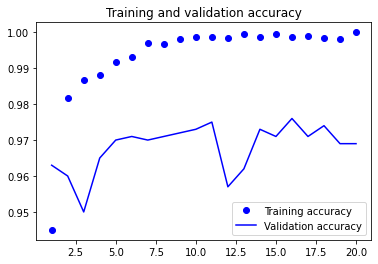

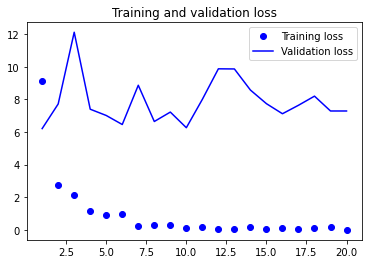

In [118]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We can clearly see that the pretrained model is working properly. We are getting better accuracy .


Feature extraction together with data augmentation

Instantiating and freezing the VGG16 convolutional base

In [119]:

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


Printing the list of trainable weights before and after freezing

In [120]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [121]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [122]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.4),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [124]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/25
157/157 [==============================] - 37s 232ms/step - loss: 0.6900 - accuracy: 0.9352 - val_loss: 0.5576 - val_accuracy: 0.9590
Epoch 2/25
157/157 [==============================] - 37s 232ms/step - loss: 0.7514 - accuracy: 0.9364 - val_loss: 0.9034 - val_accuracy: 0.9610
Epoch 3/25
157/157 [==============================] - 37s 231ms/step - loss: 0.8300 - accuracy: 0.9414 - val_loss: 0.7443 - val_accuracy: 0.9610
Epoch 4/25
157/157 [==============================] - 37s 232ms/step - loss: 0.7969 - accuracy: 0.9376 - val_loss: 0.6220 - val_accuracy: 0.9590
Epoch 5/25
157/157 [==============================] - 37s 231ms/step - loss: 0.7938 - accuracy: 0.9370 - val_loss: 0.6914 - val_accuracy: 0.9570
Epoch 6/25
157/157 [==============================] - 37s 231ms/step - loss: 0.7807 - accuracy: 0.9436 - val_loss: 0.5922 - val_accuracy: 0.9670
Epoch 7/25
157/157 [==============================] - 37s 233ms/step - loss: 0.8450 - accuracy: 0.9402 - val_loss: 0.5367 - val_ac


Evaluating the model on the test set

In [125]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 6s 183ms/step - loss: 0.2619 - accuracy: 0.9810
Test accuracy: 0.981


 We will use different technique.

We will fine tune our model by freezing all the layers but notfor the last 4 and again check our model's accuracy.


Fine-tuning a pretrained model

In [126]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Freezing all layers until the fourth from the last

In [127]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False


Fine-tuning the model

In [128]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/15
157/157 [==============================] - 98s 261ms/step - loss: 0.5565 - accuracy: 0.9532 - val_loss: 0.4041 - val_accuracy: 0.9730
Epoch 2/15
157/157 [==============================] - 41s 261ms/step - loss: 0.3278 - accuracy: 0.9538 - val_loss: 0.3723 - val_accuracy: 0.9700
Epoch 3/15
157/157 [==============================] - 41s 261ms/step - loss: 0.2651 - accuracy: 0.9530 - val_loss: 0.2072 - val_accuracy: 0.9750
Epoch 4/15
157/157 [==============================] - 41s 260ms/step - loss: 0.2243 - accuracy: 0.9476 - val_loss: 0.1689 - val_accuracy: 0.9740
Epoch 5/15
157/157 [==============================] - 41s 261ms/step - loss: 0.1678 - accuracy: 0.9566 - val_loss: 0.1881 - val_accuracy: 0.9660
Epoch 6/15
157/157 [==============================] - 41s 261ms/step - loss: 0.1630 - accuracy: 0.9554 - val_loss: 0.1530 - val_accuracy: 0.9710
Epoch 7/15
157/157 [==============================] - 41s 261ms/step - loss: 0.1282 - accuracy: 0.9592 - val_loss: 0.1207 - val_ac

In [129]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 6s 182ms/step - loss: 0.0895 - accuracy: 0.9780
Test accuracy: 0.978


It is clear that we made our model a bit better by freezing the some layers and retraining it.

**Summary**


The training sample size and chhosing a network is important, but it depends upon the settings in which we use them.

We can see that Trainig Sample Size plays an impoirtant role when we are training our model from the scratch. Large trainig samples help our model for better convergence by picking up the signals. 

In the Pretrained Model, we have the weights for the model beforehand. We just have to  run our data through it and get the outcome. But, this could be improved as well. We can freeze some it's layers and retrain the model.

By freezing some layers, we keep the weights of those layers intact. This helps us in saving alot of time and computational power.

We can train the last few layers of the model as it helps the model to grasp some special signals that might be unique to the dataset. We can get a model that works perfectly on unseen data and can be improve later .